# Introduction

This report is meant to serve as a progress report for the activities carried out in the first half of the semester and is an extension of report 3. The report is divided into three sections: the research strategy, Exploratory Data Analysis (EDA), and Model Training Results. The research strategy section provides a brief overview of the project and the research plan. The EDA section provides a detailed analysis of the data and the insights gained from the analysis. The Model Training Results section provides a summary of the model training results and the insights gained from the process.

# Research Strategy

## Brief Overview of the Project
The primary aim of this research project is to compare the performance of two models: the LSTM model and the Neural Prophet model by META (formerly known as Facebook). The comparison will be based on the USD values of two cryptocurrencies, Bitcoin and DOT. Bitcoin is chosen due to its popularity and long history, while DOT is selected for its relatively recent establishment and highly volatile price history. The performance of the models will be assessed using two criteria: the Root Mean Squared Error (RMSE) and the Mean Absolute Percentage Error (MAPE) of the predicted price.

To ensure a fair comparison, both models will undergo identical data preprocessing, model training, and model evaluation pipelines. Equal effort will be devoted to finding the optimal hyperparameters for both models within the given time frame, ensuring that they are trained with the best possible hyperparameters.

The process of tuning hyperparameters will provide valuable insights into the impact of different hyperparameters on the performance of the models. These insights will be thoroughly documented, analyzed, and presented in the final report.


## Research Project Plan
The detailed project plan is as follows:
1. ~~Data Collection~~
2. ~~Data Cleaning~~
3. Data Preprocessing
    1. ~~Sliding Window Approach for creation of time series data~~
        This method was used to generate the necessary input sequences to the model. The conducted experiments include different input sequence length with the same 1440 minutes of forecasting time step. The results of the experiments will be demonstrated in a later section.
    2. ~~Scaling and Feature Engineering~~
        Experiments on scaling have already been conducted and the results are shown in its dedicated section below
4. Model Training
    1. ~~LSTM Model Training and Hyperparameter Tuning~~
    2. Neural Prophet Model Training and Hyperparameter Tuning
5. Model Evaluation
    1. ~~Direct Forecasting~~
    2. Recursive Forecasting over a fixed time horizon with smaller model prediction intervals - ***In Progress***
6. Comparative Analysis of Model Performance and Hyperparameter Tuning - Written Submission
    1. Comparison of the model performance based on the evaluation metrics
    2. Comparison of the impact of different hyperparameters on the model performance


# Measurement strategies

## Training and Testing Data
Given that the data for this research project will be obtained through an Application Programming Interface (API), there is no specific measurement stage required to collect the necessary data. The API will serve as a direct source, providing access to real-time and historical cryptocurrency price data for Bitcoin and DOT. This eliminates the need for manual data collection or additional measurement procedures, ensuring a streamlined and efficient data acquisition process. By directly accessing the API, we can ensure the accuracy and reliability of the data, enabling a robust analysis and comparison of the LSTM and Neural Prophet models without any measurement-related uncertainties or biases.

## Generated Experimental Data

The measurement strategies employed in this research project aim to facilitate a comprehensive and fair comparison between the purely LSTM model and the Neural Prophet model by META. To ensure an unbiased evaluation, a consistent set of measurement criteria will be utilized, focusing on the USD equivalents of two cryptocurrencies: Bitcoin and DOT.

The primary measurement criteria for comparing the performance of the models will include the Root Mean Squared Error (RMSE) and the Mean Absolute Percentage Error (MAPE) of the predicted price. These metrics provide insights into the accuracy and precision of the models' price predictions. By comparing these metrics for both models, we can assess their respective strengths and weaknesses in forecasting cryptocurrency prices.

To ensure a fair comparison, identical data preprocessing, model training, and model evaluation pipelines will be implemented for both the LSTM and Neural Prophet models. This approach guarantees that any performance differences observed can be attributed solely to the characteristics and capabilities of the models themselves, rather than the specific procedures employed.

By carefully tuning the hyperparameters, we aim to maximize the performance of each model and explore the impact of different hyperparameter configurations on their predictive accuracy. The resulting insights gained from this process will be thoroughly documented, analyzed, and presented in the final research report.

# Importing the necessary libraries

In [45]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
from typing import Tuple, List, Union
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

In [32]:
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import seaborn as sns

# set the style of the plots
sns.set_style('darkgrid')
plt.style.use('seaborn')

<ipython-input-32-2279b1909a12>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# Acquiring the data

In [17]:
import sys

sys.path.append('../')
from utils.DataLoader import get_data

I have imported the data from the API using the `requests` library. The data is stored in a csv file for future use. The below code simply reads the data from the csv file into a pandas dataframe.

In [18]:
dot = pd.read_csv('../../data/DOTUSD_nonscaled.csv')
btc = pd.read_csv('../../data/BTCUSD_nonscaled.csv')

# Exploratory Data Analysis
---

Let's take a look at the data we have acquired. I will use the DOTUSD pair for this analysis at the moment.

In [19]:
dot.head(10)

,Close,Volume,Transactions
0,354.74,0.071203,1.0
1,355.34,0.010000,1.0
2,356.04,0.100000,1.0
3,339.43,5.433073,3.0
4,356.82,0.337965,1.0
5,332.35,1.600000,3.0
6,331.33,10.438179,9.0
7,335.08,6.880450,4.0
8,307.54,0.597198,5.0
9,331.67,1.056379,1.0


The data has three features: 
- `Close` - The closing price of the cryptocurrency at the end of the minute of recording
- `Volume` - The volume of the cryptocurrency traded in the minute of recording
- `Transactions` - The number of transactions that took place in the minute of recording.

In [20]:
dot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1254078 entries, 0 to 1254077
Data columns (total 3 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Close         1254078 non-null  float64
 1   Volume        1254078 non-null  float64
 2   Transactions  1254078 non-null  float64
dtypes: float64(3)
memory usage: 28.7 MB


From the output of the below cell, we can see that the data has 3 columns and 1254077 rows. And that all of the features are of the float64 datatype. The data also has no null values and hence no imputation is required. The datatypes are as expected as well

In [21]:
dot.describe()

,Close,Volume,Transactions
count,1.254078e+06,1.254078e+06,1.254078e+06
mean,1.686024e+01,1.132881e+03,2.612756e+01
std,1.306936e+01,2.589239e+03,4.299496e+01
min,2.802600e+00,1.000000e-08,1.000000e+00
25%,6.342000e+00,9.751081e+01,6.000000e+00
50%,1.224900e+01,4.103137e+02,1.400000e+01
75%,2.533500e+01,1.189890e+03,3.100000e+01
max,3.568200e+02,2.018216e+05,4.215000e+03


In the above table we can observe some simple statistics about the data. At this instance the variable of interest is the Close Price. We can see that the standard deviation is quite high, which means that the data is rather spread out and does not have a high degree of central tendency. 

Let's take a look at the data itself visually and its distribution.

Text(0, 0.5, 'Price')

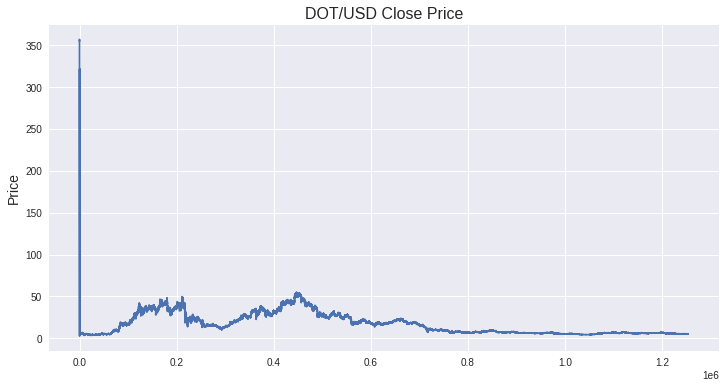

In [22]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(dot['Close'])
ax.set_title('DOT/USD Close Price', fontsize=16)
ax.set_ylabel('Price', fontsize=14)

If we take a look at the above plot, we can see that the data has a strong outlierish behaviour at the start of the recording period. The initial price of the Polkadot (DOT) cryptocurrency was high at the time of its launch due to several factors including the strong team behind the project, its innovative technology, and high demand from investors looking for new opportunities in the growing blockchain industry. Additionally, the supply of DOT tokens was limited at the time of launch. In addition to this, unlike most of the newly launched cryptocurrencies, DOT was not available for purchase on any major cryptocurrency exchanges. This meant that the only way to acquire DOT tokens was through the Polkadot ICO, which was only open to accredited investors. This resulted in a high demand for DOT tokens, which drove up the price of the cryptocurrency.

It is for this reason that the data at the start of the recording period is not representative of the actual market conditions. As such, we will remove the first 1000 rows of data from the dataset to eliminate this outlierish behaviour.

Text(0, 0.5, 'Price')

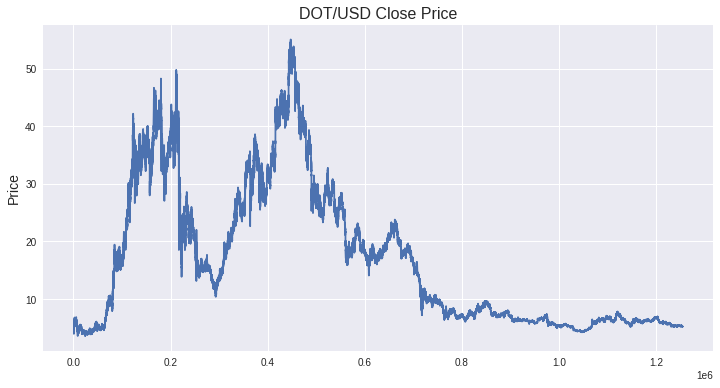

In [23]:
dot = dot.iloc[1000:, :]

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(dot['Close'])
ax.set_title('DOT/USD Close Price', fontsize=16)
ax.set_ylabel('Price', fontsize=14)

Now we can see that the data is more reminiscent of the actual market conditions. The data is still quite spread out, but it is more representative of the actual market conditions. It should be noted that the data is still not normally distributed, but this is to be expected given the nature of the cryptocurrency market. And as such, we will not perform any transformations on the data. However, let's take a look at the data before and after performing a few transformations.

In [35]:
from typing import Union


def plot_distribution(data: pd.DataFrame, col: str, bins: int = 50, 
                      ax: Union[Axes, None] = None) -> None:
    """
    Plots the distribution of a given column
    """
    
    if not ax:
        fig, ax = plt.subplots(figsize=(12, 6))

    ax.hist(data[col], bins=bins)    
    # add a vertical line at the mean
    ax.axvline(data[col].mean(), color='red', ls='--', label='mean')
    # add a vertical line at the median
    ax.axvline(data[col].median(), color='green', ls='--', label='median')


    ax.set_title(f'Distribution of {col}', fontsize=16)
    ax.set_xlabel(col, fontsize=14)
    ax.set_ylabel('Frequency', fontsize=14)
    ax.legend()

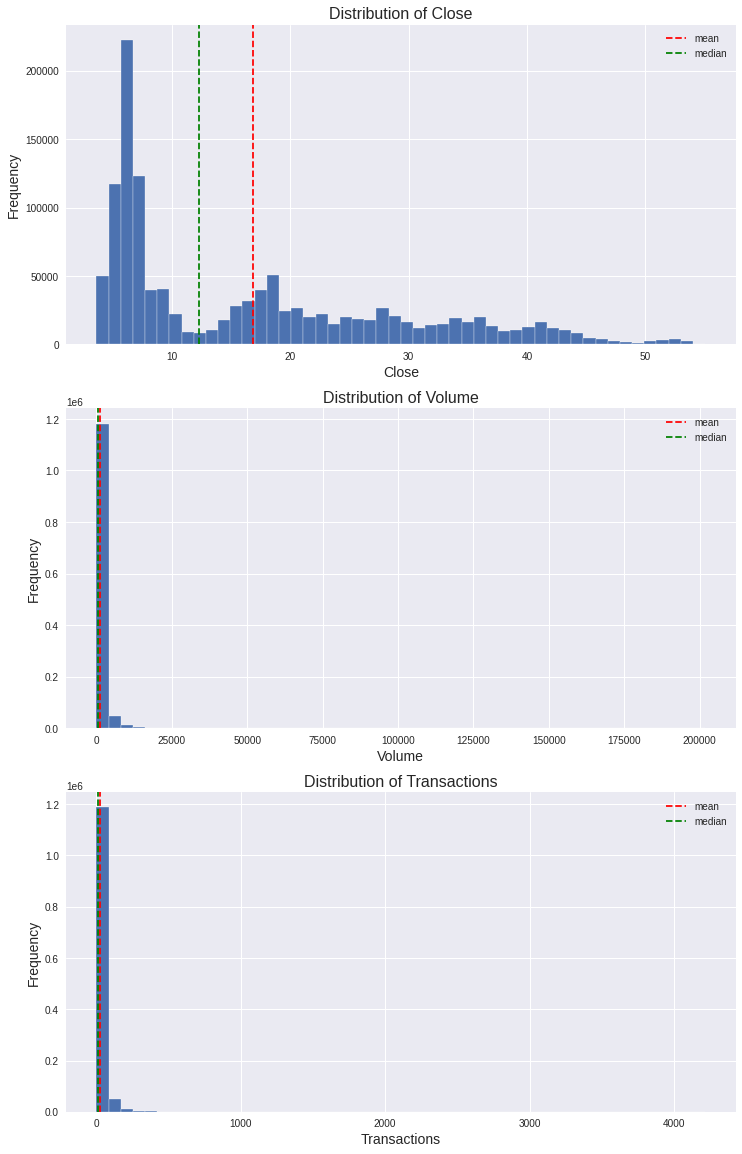

In [36]:
# plot the distribution of the data
fig, [ax0, ax1, ax2] = plt.subplots(figsize=(12, 20), nrows=3, ncols=1)

plot_distribution(dot, 'Close', bins=50, ax=ax0)
plot_distribution(dot, 'Volume', bins=50, ax=ax1)
plot_distribution(dot, 'Transactions', bins=50, ax=ax2)

From the above distributions we can see that the data is not normally distributed. This is to be expected given the nature of the cryptocurrency market. Especially when it comes to the Transactions and the Volumes variables, there is a high degree of skewness. This is because the majority of the transactions and volumes are concentrated in a few minutes of the recording period. This is a common phenomenon in the cryptocurrency market, where high volume or high transaction activities can take place arbitrarily at any time. This is why the data is not normally distributed. There are usually some big players in the market who can influence the price of the cryptocurrency by buying or selling large amounts of the cryptocurrency at any given time.

Let's see if the periods of high activity or high stake trading have any impact on the price of the cryptocurrency.

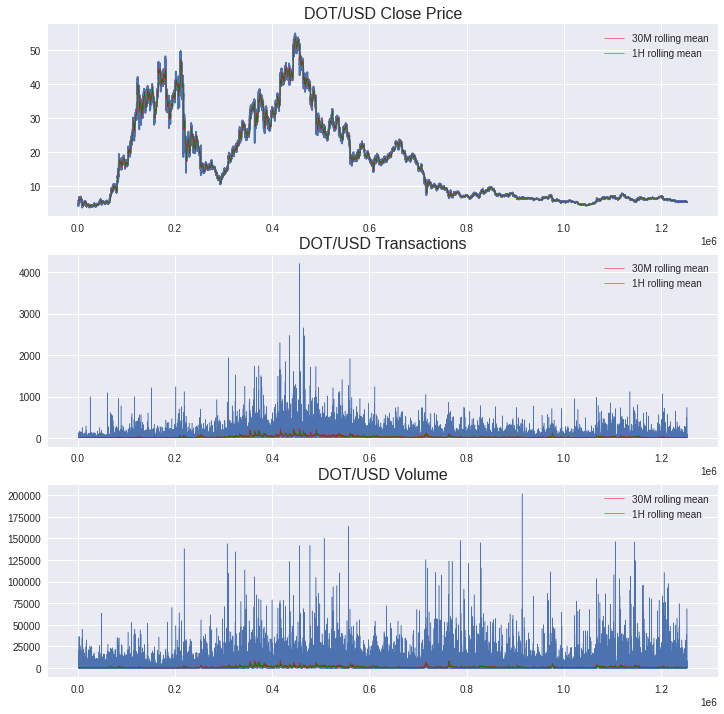

In [42]:
# plot the price, volume and transactions

fig, [ax0, ax1, ax2] = plt.subplots(figsize=(12, 12), nrows=3, ncols=1)

# plot the price
ax0.plot(dot['Close'])
ax0.set_title('DOT/USD Close Price', fontsize=16)
# add a smoothed line using rolling mean for 12 and 24 hour windows
ax0.plot(dot['Close'].rolling(60*12).mean(), color='red', label='30M rolling mean', linewidth=0.5)
ax0.plot(dot['Close'].rolling(60*24).mean(), color='green', label='1H rolling mean', linewidth=0.5)
ax0.legend()

# plot the transactions
ax1.plot(dot['Transactions'], linewidth=0.5)
ax1.set_title('DOT/USD Transactions', fontsize=16)
# add a smoothed line using rolling mean for 12 and 24 hour windows
ax1.plot(dot['Transactions'].rolling(60*12).mean(), color='red', label='30M rolling mean', linewidth=0.5)
ax1.plot(dot['Transactions'].rolling(60*24).mean(), color='green', label='1H rolling mean', linewidth=0.5)
ax1.legend()

# plot the volume
ax2.plot(dot['Volume'], linewidth=0.5)
ax2.set_title('DOT/USD Volume', fontsize=16)
# add a smoothed line using rolling mean for 12 and 24 hour windows
ax2.plot(dot['Volume'].rolling(60*12).mean(), color='red', label='30M rolling mean', linewidth=0.5)
ax2.plot(dot['Volume'].rolling(60*24).mean(), color='green', label='1H rolling mean', linewidth=0.5)
ax2.legend()

From the above plots, we can see that the periods of high activity or high stake trading do not have a significant impact on the price. It is true that there are some periods when either high volume or high density activity coincide with the price movemenets, but these are not significant enough to be considered as a pattern. 

Let's see if there is any correlation between the variables. This will allow us to test the above stated hypothesis.

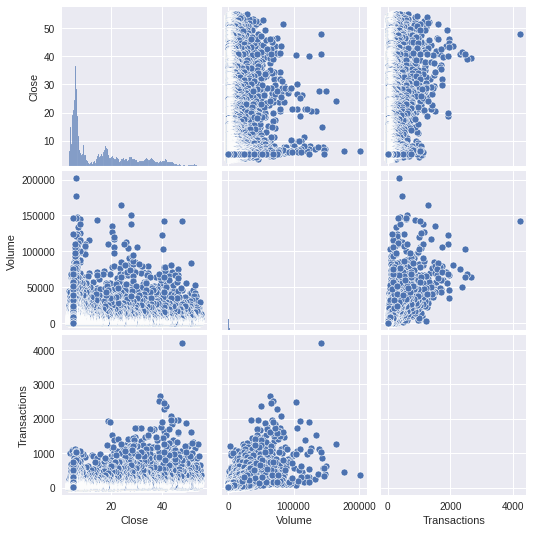

In [43]:
# plot pairplot
sns.pairplot(dot)

<AxesSubplot: >

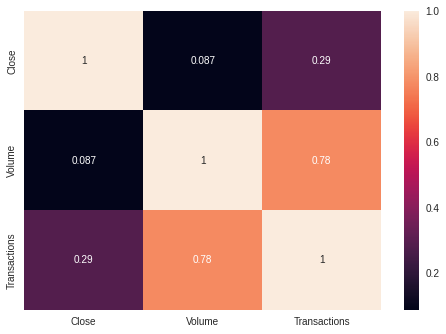

In [44]:
# plot correlation matrix
sns.heatmap(dot.corr(), annot=True)

The hypothesis that that the periods of high activity or high stake trading do not have a significant impact on the price of the cryptocurrency in fact holds true. From the above correlation matrix and the pairplot we can see that there is no significant correlation between the said variables. 

However, we can observe that there is a strong correlation between the Volume and the Transactions variables. This is to be expected as the number of transactions is directly proportional to the volume of the cryptocurrency traded. The instances when this is not the case refer to the activities of individuals who are trading with high cashflow over a very limited number of transactions or trading bots that are programmed to trade at a high frequency with a low volume per transaction.

As stated before, the data is not normally distributed. This is to be expected given the nature of the cryptocurrency market. Especially when it comes to the Transactions and the Volumes variables, there is a high degree of skewness. Considering the nature of the data, we will not perform any transformations on the data. However, let's take a look at the data before and after performing a few transformations.

In [49]:
close_price = dot.Close.values.reshape(-1, 1)

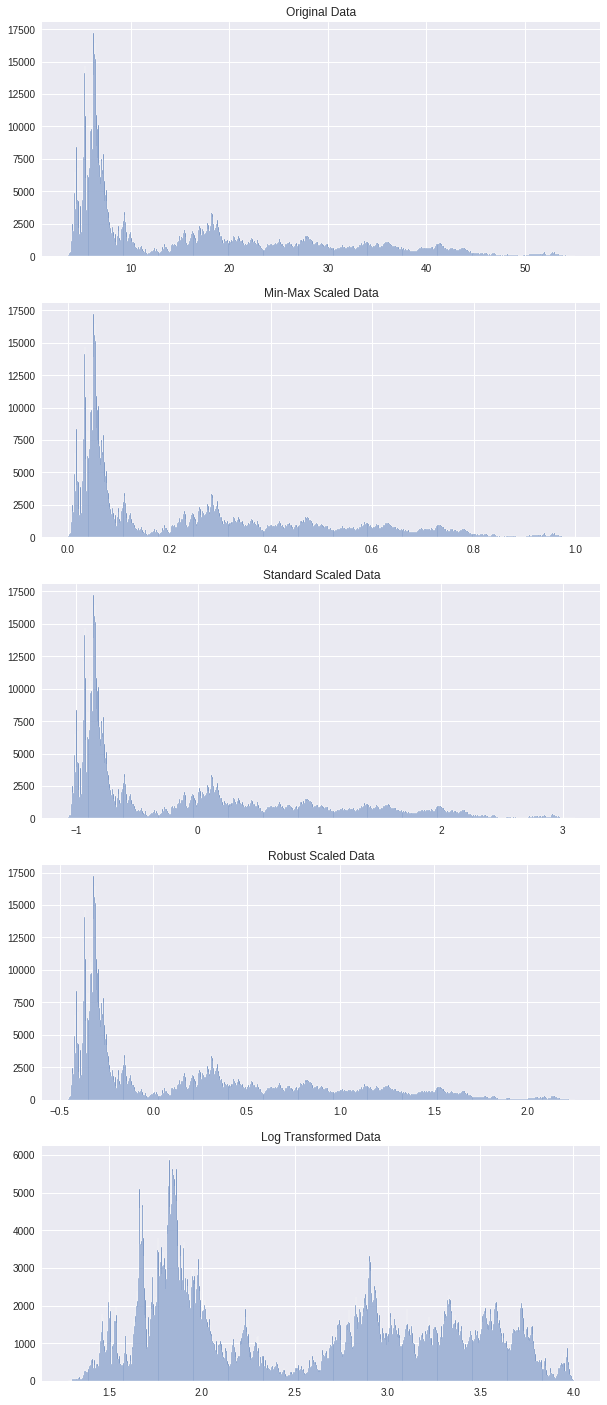

In [50]:
nrows = 5
ncols = 1

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, nrows * 5))

# plot the distribution of original data
axes[0].hist(close_price, bins=1000)
axes[0].set_title("Original Data")

# min-max scale the data and add to the figure
mm_scaler = MinMaxScaler()
mm_scaled_data = mm_scaler.fit_transform(close_price)
axes[1].hist(mm_scaled_data, bins=1000)
axes[1].set_title("Min-Max Scaled Data")

# standard scale the data and add to the figure
std_scaler = StandardScaler()
std_scaled_data = std_scaler.fit_transform(close_price)
axes[2].hist(std_scaled_data, bins=1000)
axes[2].set_title("Standard Scaled Data")

# robust scale the data and add to the figure
rb_scaler = RobustScaler()
rb_scaled_data = rb_scaler.fit_transform(close_price)
axes[3].hist(rb_scaled_data, bins=1000)
axes[3].set_title("Robust Scaled Data")

# log transform the data and add to the figure
log_data = np.log(close_price)
axes[4].hist(log_data, bins=1000)
axes[4].set_title("Log Transformed Data")

plt.show()

A quick glance at the above charts depict that the impact of the transformations is not significant. The data is still not normally distributed. MinMax scaling simply fits the data to the [0, 1] range and does not scale the data to a normal distribution due to its nature. Standard and Robust scaling do not display any noteworthy changes in the distribution of the data either. The changes observed after applying these transformations are limited to simply squeezing the distribution to a smaller range with the latter method being more robust to outliers and thus resulting in a more compact distribution.

In fact, during my testings over the data, the models performed better on the data that was not transformed. Applying MinMax scaling for easier gradient descent alone was sufficient in my testings.

***Note:*** I will post a separate data preprocessing report that will go into more detail about how I transform the data to make it suitable for the models.